In [1]:
import os
import typing
import warnings

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import missingno as msno 
import matplotlib as mpl
from scipy.stats import zscore
import matplotlib.pyplot as plt


from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important}; </style>"))

In [2]:
warnings.filterwarnings(
    action='ignore',
    message='înternal gelsd'
)

In [3]:
np.random.seed(1)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

In [4]:
# Matplotlib set label size
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

In [5]:
sns.set_style('whitegrid')
sns.set_context(
    'notebook',
    font_scale=1,
    rc={
        'lines.linewidth': 2,
        'font.family': [u'times']
    }
)

## Data Loading

We have multiple houses, and we want to predict their **market price**.
So we are going to explore the features that we have.

In [6]:
train_set = pd.read_csv('./data/train_set.csv', index_col=0)
test_set = pd.read_csv('./data/test_set.csv', index_col=0)

In [7]:
print('Number of samples: ', train_set.shape[0])
print('Number of features: ', test_set.shape[1])

Number of samples:  5432
Number of features:  20


In [8]:
train_set.head(3)

Suburb         Address  Rooms Type      Price Method SellerG  \
index                                                                       
0        Aberfeldie  241 Buckley St      4    h  1380000.0     VB  Nelson   
1         Northcote   67 Charles St      2    h  1100000.0     SP  Jellis   
2      Balwyn North      42 Maud St      3    h  1480000.0     PI  Jellis   

             Date  Distance  Postcode  Bedroom2  Bathroom  Car  Landsize  \
index                                                                      
0      12/08/2017       7.5    3040.0       4.0       2.0  2.0     766.0   
1      20/05/2017       5.5    3070.0       2.0       1.0  1.0     189.0   
2      15/10/2016       9.2    3104.0       3.0       1.0  4.0     605.0   

       BuildingArea  YearBuilt    CouncilArea  Lattitude  Longtitude  \
index                                                                  
0               NaN        NaN  Moonee Valley  -37.75595   144.90551   
1               NaN        NaN        Darebin  -37.77670   144.99240   
2             116.0     1950.0     Boroondara  -37.79510   145.06960   

                  Regionname  Propertycount  
index                                        
0       Western Metropolitan         1543.0  
1      Northern Metropolitan        11364.0  
2      Southern Metropolitan         7809.0

## Data Exploration

In [9]:
def diplay_unique_values(df: pd.DataFrame):
    for column in train_set.columns.values:
        print(f'{column.capitalize()} - {train_set[column].dtype} - ', train_set[column].nunique())
    
diplay_unique_values(train_set)

Suburb - object -  292
Address - object -  5400
Rooms - int64 -  8
Type - object -  3
Price - float64 -  1458
Method - object -  5
Sellerg - object -  203
Date - object -  58
Distance - float64 -  194
Postcode - float64 -  187
Bedroom2 - float64 -  11
Bathroom - float64 -  9
Car - float64 -  10
Landsize - float64 -  1131
Buildingarea - float64 -  435
Yearbuilt - float64 -  121
Councilarea - object -  32
Lattitude - float64 -  3568
Longtitude - float64 -  3790
Regionname - object -  8
Propertycount - float64 -  289


In [10]:
# In the case of the Addres, we can see that would not provide a lot of information to have such a categorical variable
train_set.drop(['Address'], axis=1, inplace=True)
test_set.drop(['Address'], axis=1, inplace=True)

In [11]:
# We can sort the values on the year of built, which will help for some visualizations
train_set = train_set.sort_values(['YearBuilt'])
test_set = test_set.sort_values(['YearBuilt'])

In [12]:
train_set.head(5)

Suburb  Rooms Type      Price Method   SellerG        Date  \
index                                                                        
4034       Collingwood      2    u   855000.0      S    Nelson   3/09/2016   
2872           Fitzroy      4    h  3310000.0      S     Caine  13/08/2016   
4823   South Melbourne      4    h  2260000.0     PI  Marshall   7/05/2016   
3285   South Melbourne      4    h  2180000.0      S  Marshall  10/12/2016   
4614           Fitzroy      4    h  3200000.0     VB    Nelson  12/08/2017   

       Distance  Postcode  Bedroom2  Bathroom  Car  Landsize  BuildingArea  \
index                                                                        
4034        1.6    3066.0       2.0       1.0  1.0    2886.0         122.0   
2872        1.6    3065.0       4.0       4.0  2.0     337.0         291.0   
4823        2.1    3205.0       5.0       3.0  0.0     190.0         232.0   
3285        2.1    3205.0       4.0       3.0  1.0     200.0         153.0   
4614        2.1    3065.0       4.0       4.0  0.0     225.0           NaN   

       YearBuilt   CouncilArea  Lattitude  Longtitude             Regionname  \
index                                                                          
4034      1830.0         Yarra  -37.80420   144.98450  Northern Metropolitan   
2872      1854.0         Yarra  -37.80520   144.97390  Northern Metropolitan   
4823      1856.0  Port Phillip  -37.83770   144.96530  Southern Metropolitan   
3285      1860.0  Port Phillip  -37.83600   144.96500  Southern Metropolitan   
4614      1862.0         Yarra  -37.80209   144.97443  Northern Metropolitan   

       Propertycount  
index                 
4034          4553.0  
2872          5825.0  
4823          5943.0  
3285          5943.0  
4614          5825.0

In [38]:
train_set.describe()

Rooms         Price     Distance     Postcode     Bedroom2  \
count  5214.000000  5.214000e+03  5214.000000  5214.000000  5214.000000   
mean      2.892405  9.985347e+05    10.324242  3106.001918     2.875719   
std       0.926478  4.867759e+05     6.040775    96.447161     0.965496   
min       1.000000  1.450000e+05     0.000000  3000.000000     0.000000   
25%       2.000000  6.400000e+05     6.300000  3044.000000     2.000000   
50%       3.000000  8.822500e+05     9.300000  3084.000000     3.000000   
75%       3.000000  1.279000e+06    13.100000  3148.000000     3.000000   
max       8.000000  3.000000e+06    48.100000  3977.000000    20.000000   

          Bathroom          Car      Landsize  BuildingArea    YearBuilt  \
count  5214.000000  5189.000000   5214.000000   2767.000000  3177.000000   
mean      1.498849     1.604548    530.747411    159.546625  1965.967579   
std       0.663003     0.971900   1580.379151    861.238176    35.744121   
min       0.000000     0.000000      0.000000      0.000000  1830.000000   
25%       1.000000     1.000000    178.250000     91.000000  1950.000000   
50%       1.000000     2.000000    435.500000    123.000000  1970.000000   
75%       2.000000     2.000000    649.750000    168.000000  2000.000000   
max       8.000000    10.000000  75100.000000  44515.000000  2018.000000   

         Lattitude   Longtitude  Propertycount    Price_log  
count  5214.000000  5214.000000    5214.000000  5214.000000  
mean    -37.808485   144.994702    7449.931530    13.699455  
std       0.079998     0.107884    4408.917063     0.483851  
min     -38.174880   144.542370     389.000000    11.884489  
25%     -37.856180   144.927755    4263.500000    13.369223  
50%     -37.800530   144.999500    6543.000000    13.690231  
75%     -37.754925   145.059200   10331.000000    14.061588  
max     -37.408530   145.526350   21650.000000    14.914123

We can see there are no strange negative values.

In [13]:
# We can assess how many nulls we have from each column
nan_cols = train_set.columns[train_set.isna().any()].tolist()

for nan_col in nan_cols:
    print(f'Column {nan_col}:', train_set[nan_col].isna().sum())

Column Car: 25
Column BuildingArea: 2542
Column YearBuilt: 2130
Column CouncilArea: 553


In [37]:
# TODO: Might be the ones without car could be removed --> make sure those examples are not relevant

<AxesSubplot: >

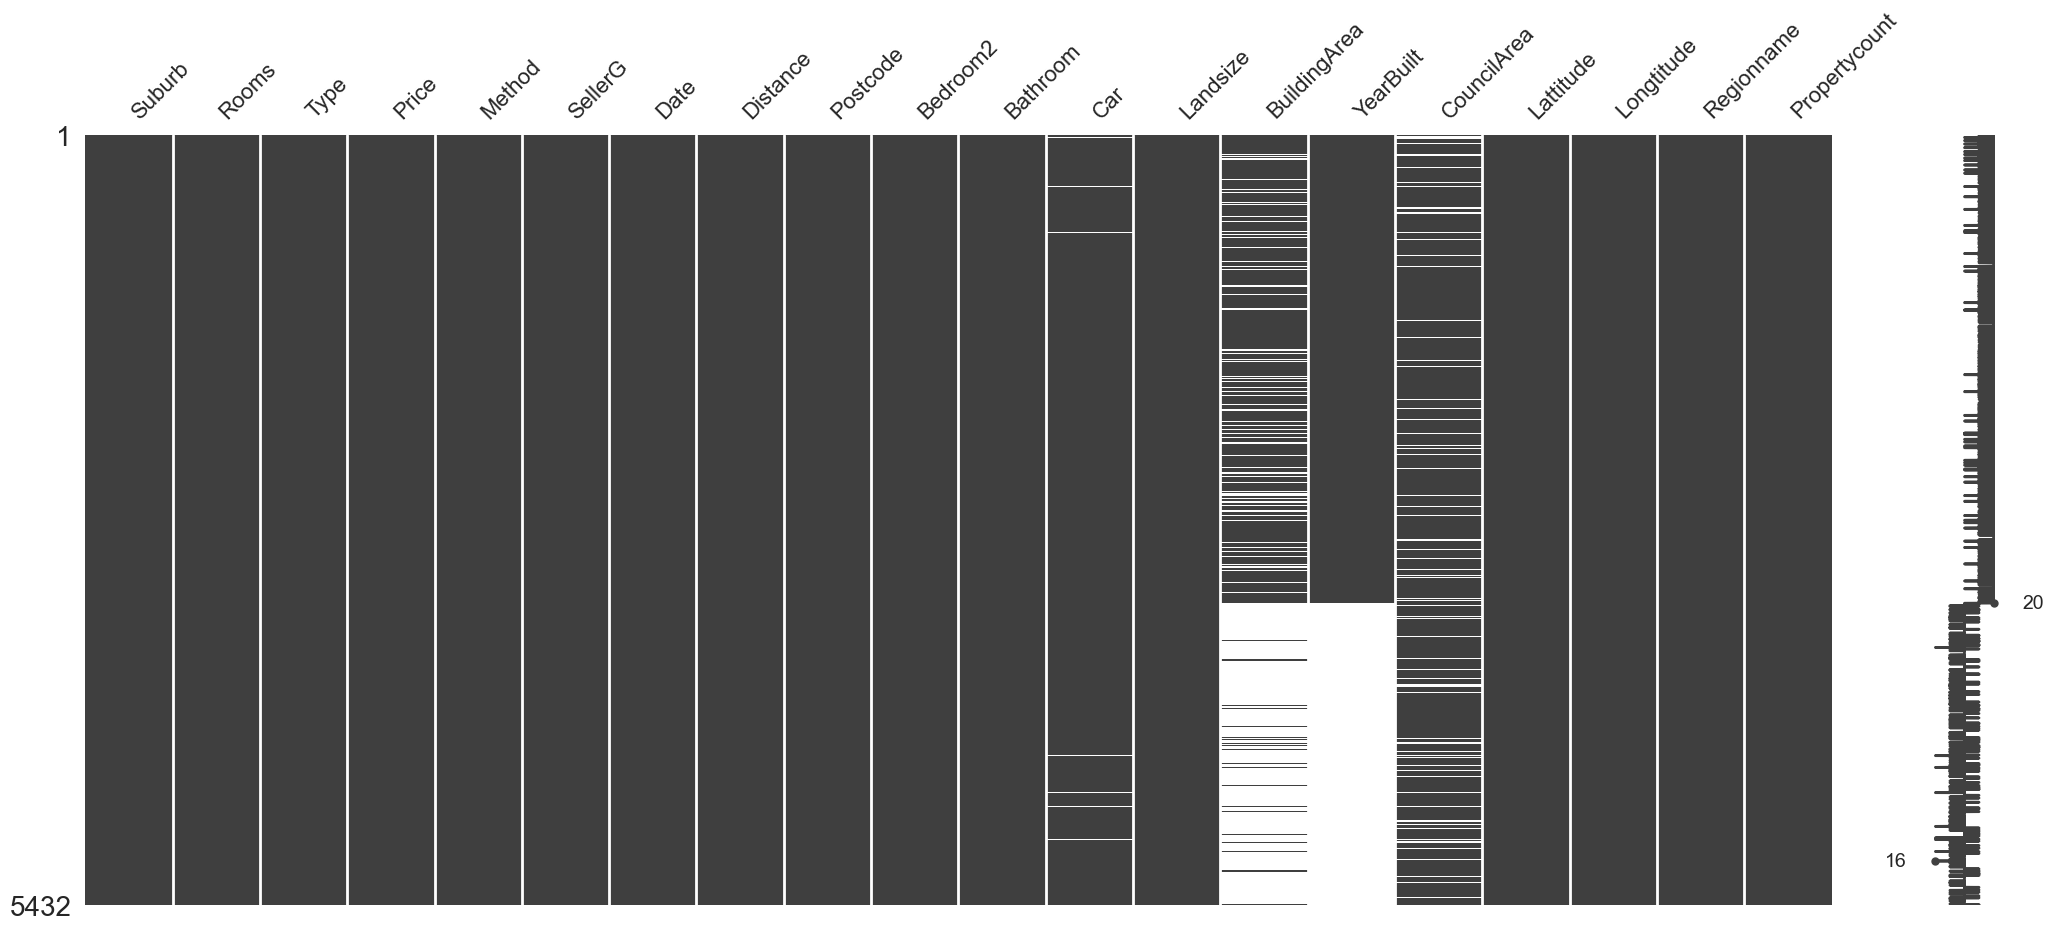

In [14]:
msno.matrix(
    train_set
)

We can see that for the null years of building, we are missing a lot of values for `BuildingArea` column.

<AxesSubplot: >

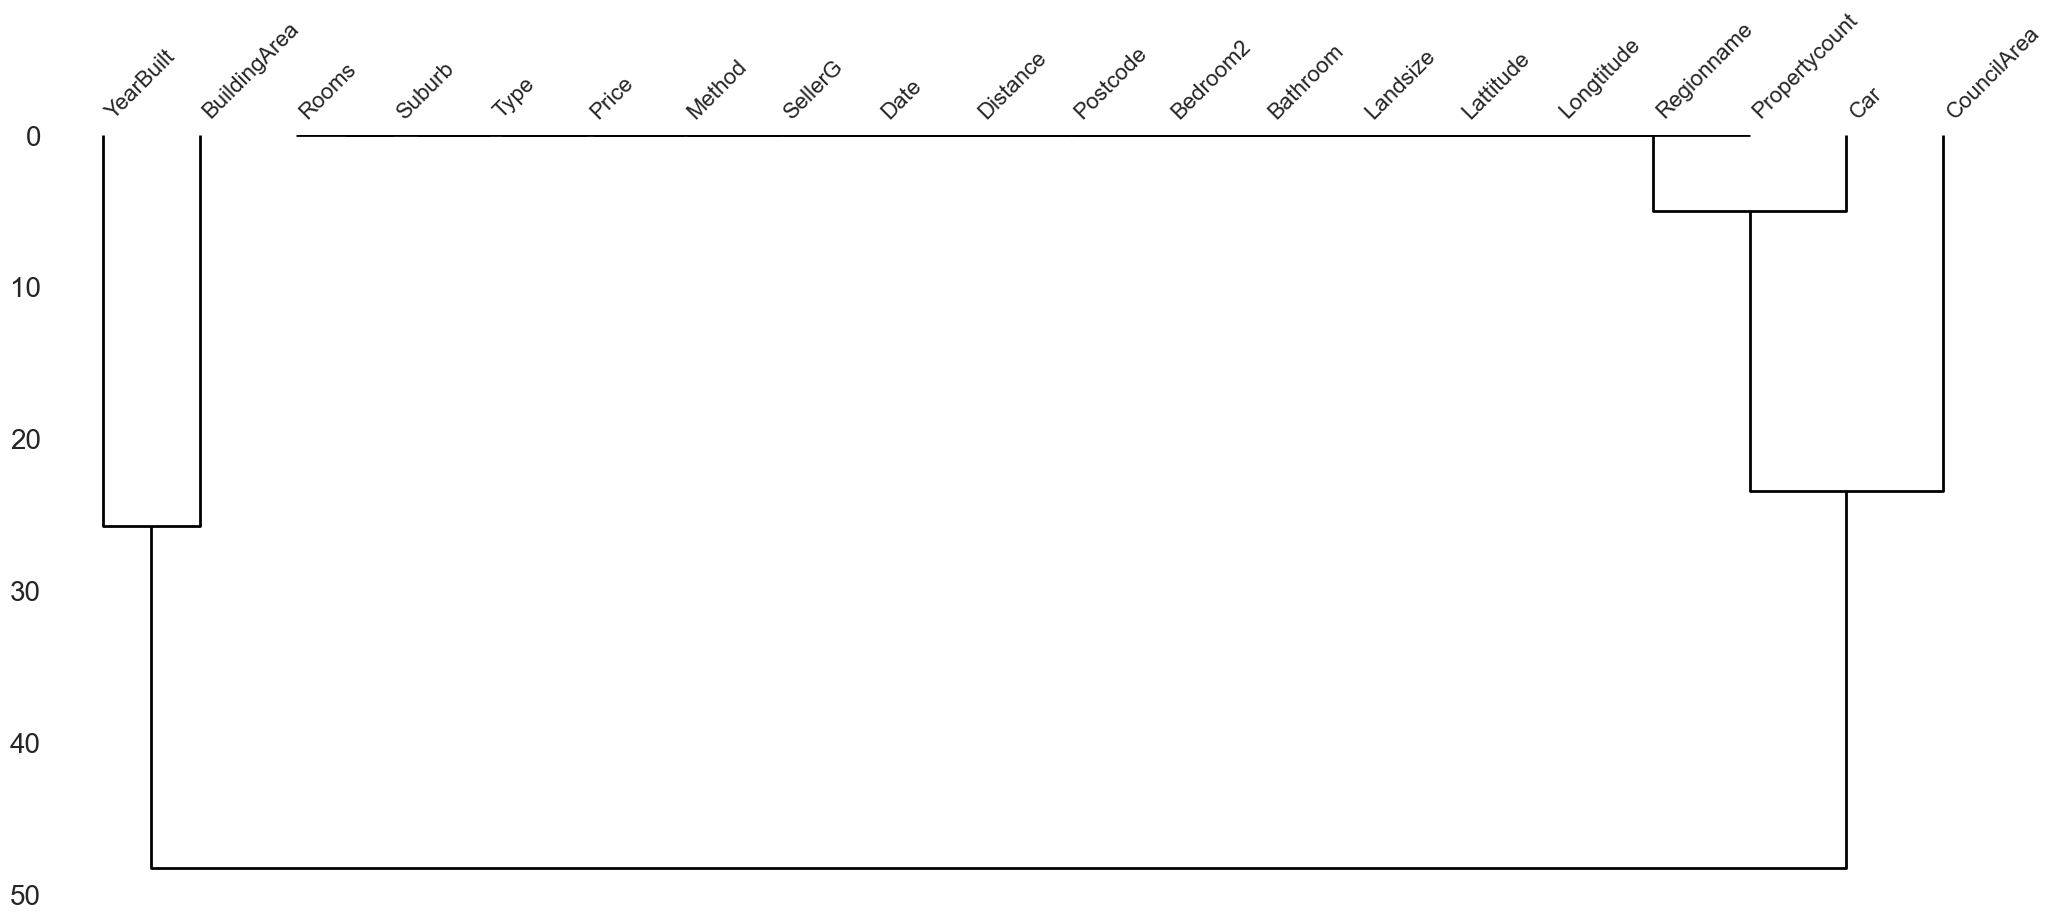

In [15]:
# We can also use a dendogram for analyzing this nullity relation
msno.dendrogram(train_set)

We can now see that we have also a bit of nullity relation between `Propertycount`, `Car`, and then with `CouncilArea`.

### Categorical Variables

In [16]:
# Can take a closer look to the object ones
train_set.select_dtypes(include=['object']).head(3)

Suburb Type Method   SellerG        Date   CouncilArea  \
index                                                                    
4034       Collingwood    u      S    Nelson   3/09/2016         Yarra   
2872           Fitzroy    h      S     Caine  13/08/2016         Yarra   
4823   South Melbourne    h     PI  Marshall   7/05/2016  Port Phillip   

                  Regionname  
index                         
4034   Northern Metropolitan  
2872   Northern Metropolitan  
4823   Southern Metropolitan

### Type

<AxesSubplot: xlabel='count', ylabel='Type'>

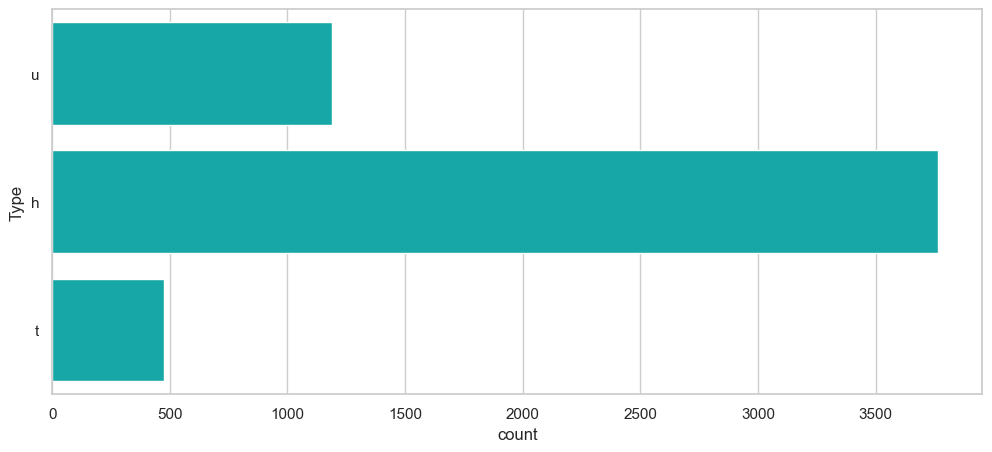

In [17]:
sns.countplot(
    y='Type',
    data=train_set,
    color='c'
)

We have the different types:
- **h**: hourse, cottage, villa, semi, terrace
- **u**: unit, duplex
- **t**: townhouse

And we can see that the majority of them are of type *h*.

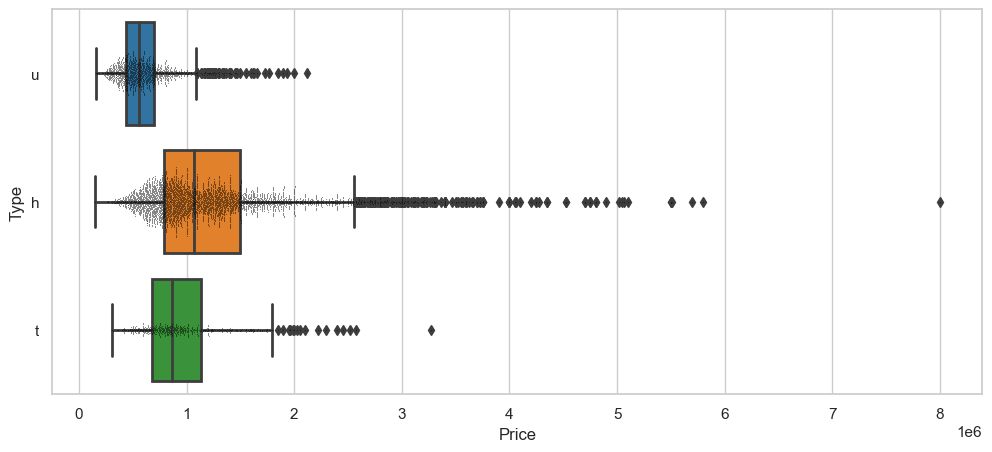

In [18]:
sns.boxplot(
    x='Price',
    y='Type',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Type", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

We can see important outliers.

Will create a function that removes the outliers grouping by certain categorical variables.

In [19]:
# We will compute the z-score for the prices of houses grouping by the region, and removing outliers (z-score > 3)
def rm_categorical_price_outlier(
    df: pd.DataFrame,
    target_col: str = 'Price',
    group_cols: typing.List[str] = ['Type', 'Method', 'Regionname'],
    bound: typing.Tuple[float, float] = (-3., 3.)
) -> typing.List[int]:
    
    all_dropped = []
    
    for group_col in group_cols:
        for group in df[group_col].unique():
            df_subset = df.loc[df[group_col] == group, target_col].to_frame()
            subset_z_score = df_subset.apply(zscore)

            # And now we drop those indices of the rows that have z-score out of bounds (-3, 3)
            to_drop = list(
                (subset_z_score[(subset_z_score > bound[1]).values].index)) + list(
                (subset_z_score[(subset_z_score < bound[0]).values].index)
            )
            all_dropped += to_drop

            df.drop(
                to_drop, 
                axis=0, 
                inplace=True
            )
    
    return df, all_dropped

In [20]:
train_set, _ = rm_categorical_price_outlier(train_set)

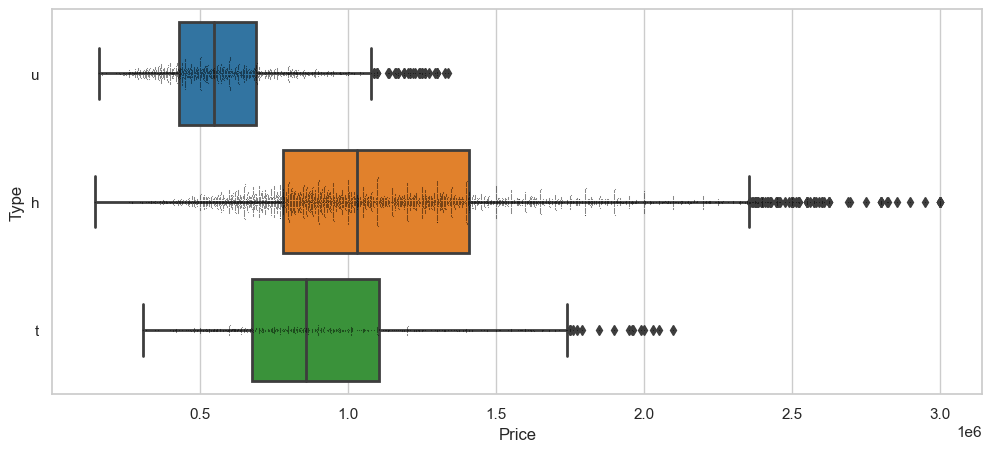

In [21]:
# And can compare with the before plot
sns.boxplot(
    x='Price',
    y='Type',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Type", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

We can make a qqplot to see if there is normality of the pricess grouping by this categorical variable.

In [22]:
def qqplot_price_category(
    df: pd.DataFrame, 
    category_group: str,
    target_col: typing.Optional[str] = 'Price',
    input_shape: typing.Optional[typing.List[int]] = [1, 3],
    delete_last: typing.Optional[bool] = False
):
    # Consider normality of price distribution in each group to apply ANOVA 
    fig, axs = plt.subplots(input_shape[0], input_shape[1], figsize=(16, 14))

    x_row, y_col = 0, -1
    for idx, value in enumerate(df[category_group].unique()):
        x_row = x_row + 1 if idx % 3 == 0 and idx > 0 else x_row
        y_col = y_col - 2 if idx % 3 == 0 and idx > 0 else y_col + 1
        
        region_set = df.loc[df[category_group].eq(value), target_col]
        
        ax = axs[x_row, y_col] if input_shape[0] > 1 else axs[idx]

        pg.qqplot(
            region_set, 
            dist='norm', 
            ax=ax
        )
        ax.set_title(value)

    plt.tight_layout()
    
    if delete_last:
        fig.delaxes(axs[input_shape[0] - 1][input_shape[1] - 1])

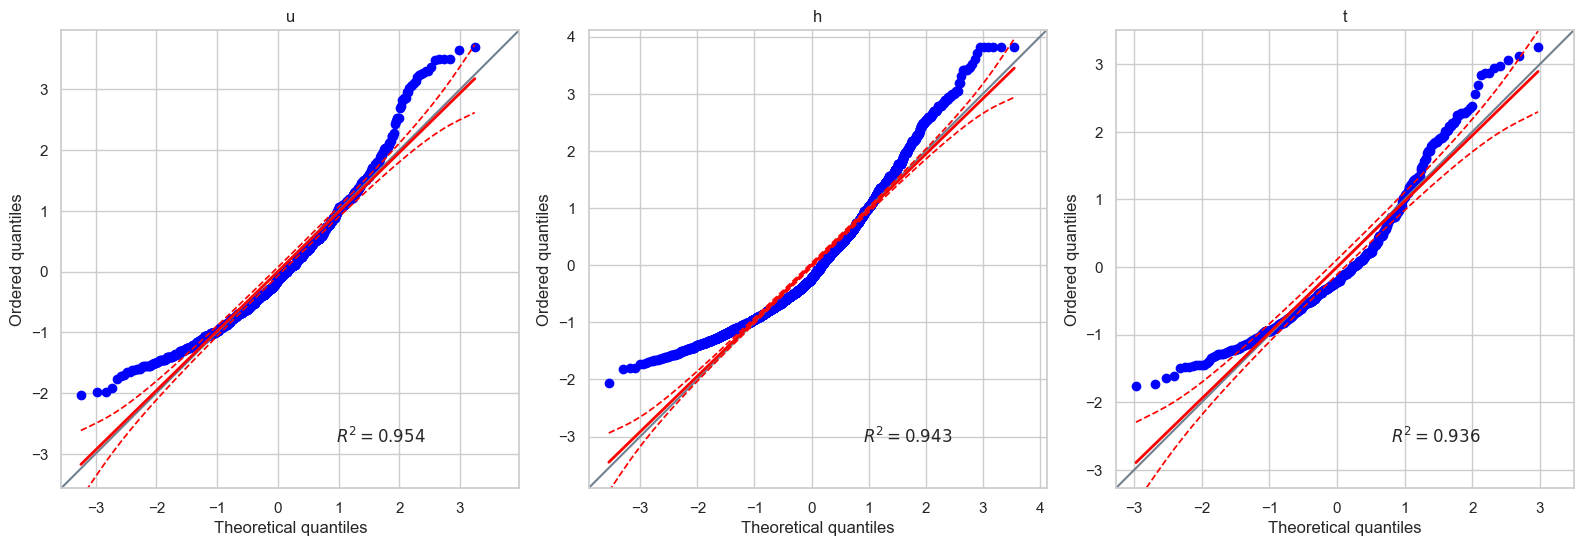

In [23]:
qqplot_price_category(
    train_set,
    category_group='Type'
)

In [24]:
# We can make Levene homoscedasticity test
pg.homoscedasticity(
    data=train_set, 
    dv='Price', 
    group='Type', 
    method='levene'
)

W           pval  equal_var
levene  277.16581  4.075313e-115      False

### Region Name

Visualize a boxplot with the outliers also removed for this categorical variable.

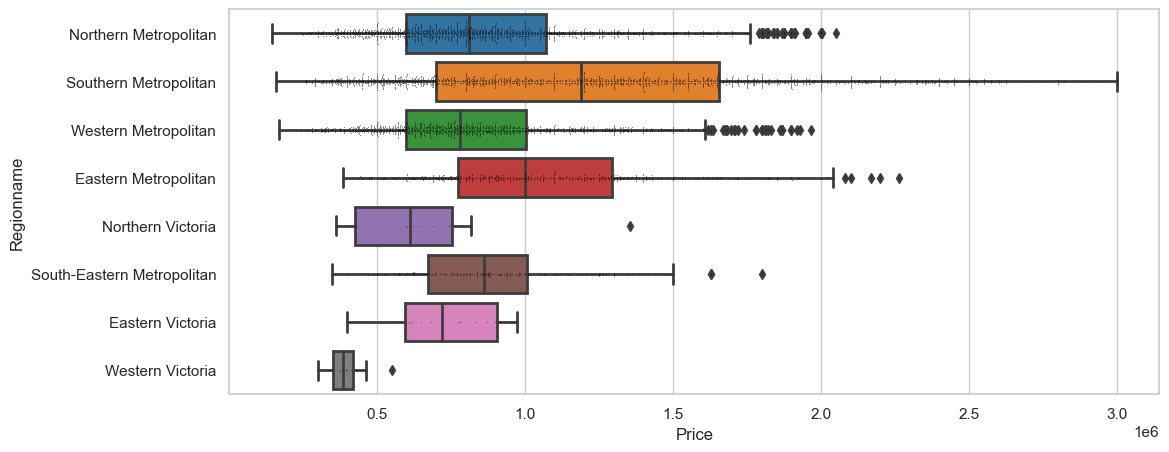

In [25]:
sns.boxplot(
    x='Price',
    y='Regionname',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Regionname", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

We can still see that there is a difference in the visualization on the distribution.

We might have to do a test to know if this difference of distributions is important to take into consideration. For this, we could make an ANOVA test.

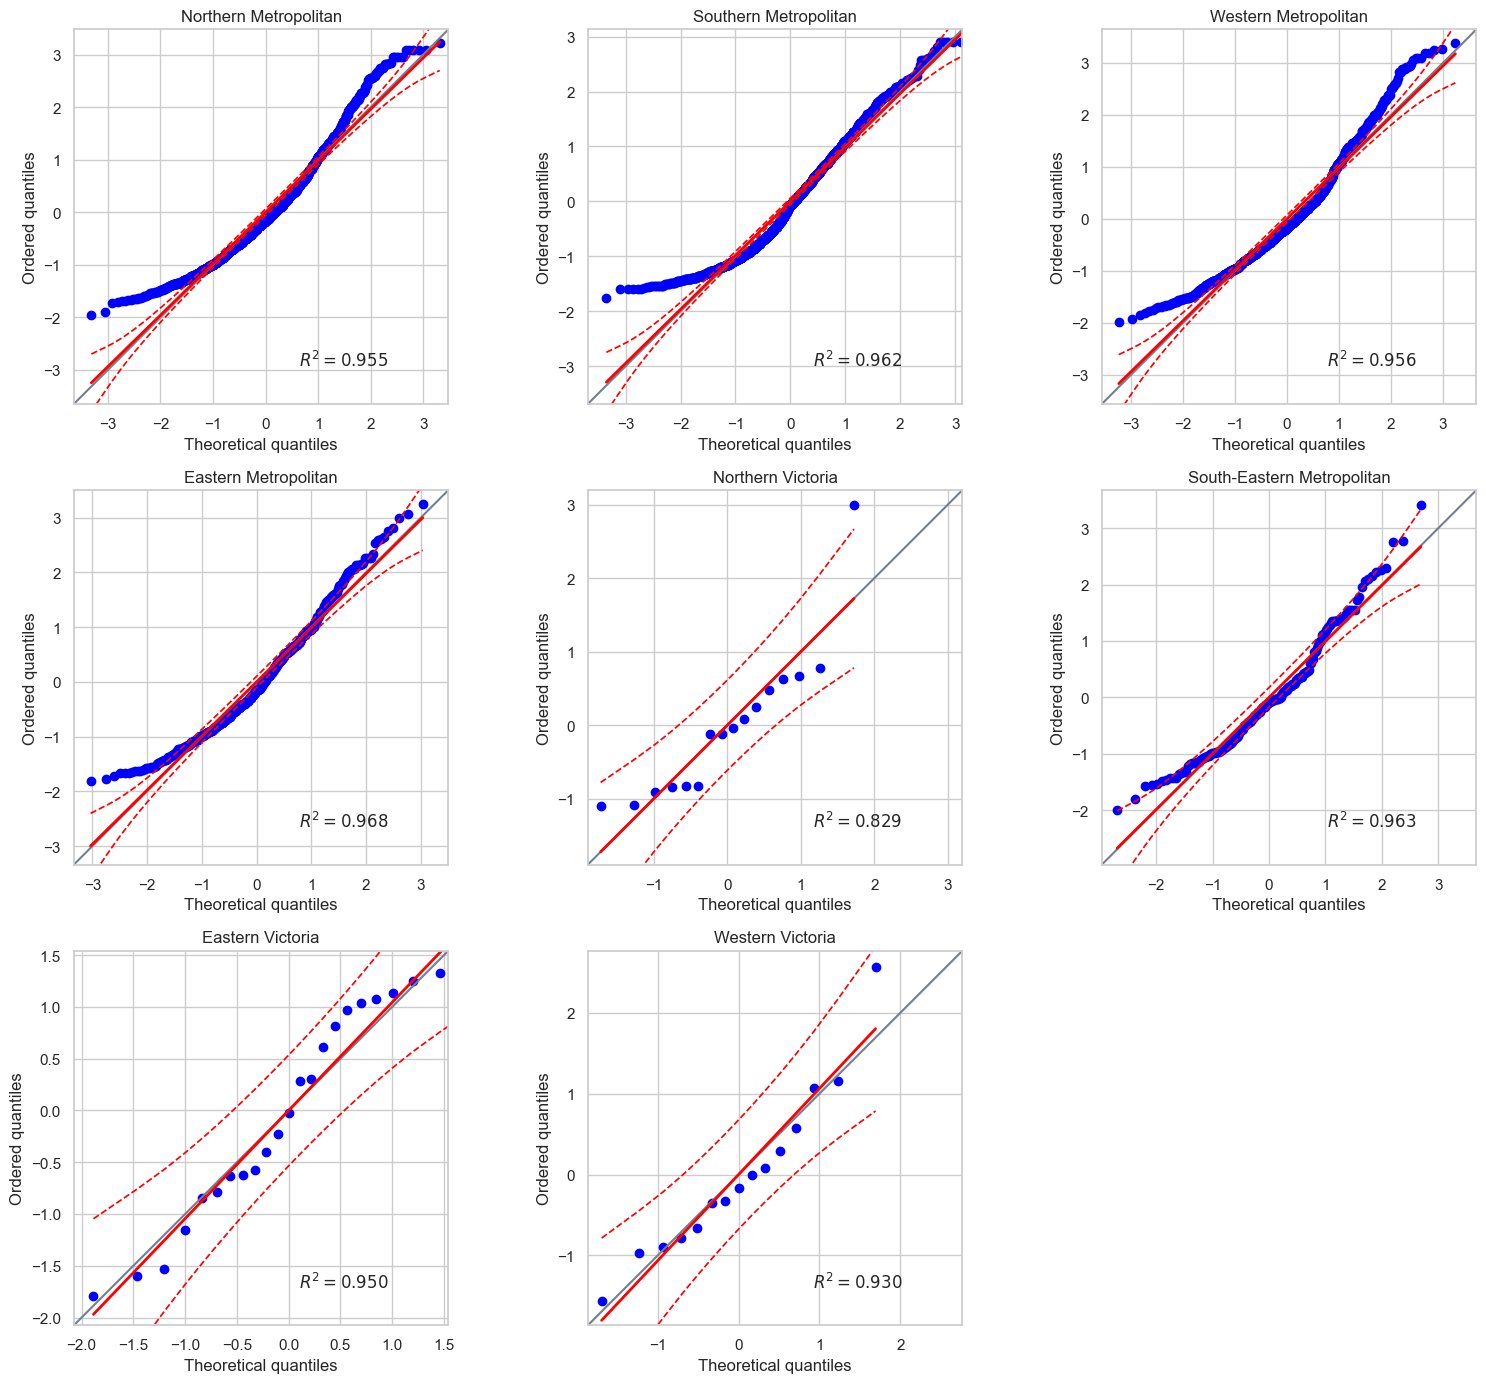

In [26]:
qqplot_price_category(
    train_set,
    category_group = 'Regionname',
    input_shape = [3, 3],
    delete_last=True
)

In [27]:
# We can also make the test Shapiro-Wilk to assess the normality
pg.normality(
    data=train_set, 
    dv='Price', 
    group='Regionname'
)

W          pval  normal
Regionname                                                
Northern Metropolitan       0.954292  2.700313e-21   False
Southern Metropolitan       0.960821  3.598655e-21   False
Western Metropolitan        0.955034  2.199855e-18   False
Eastern Metropolitan        0.967214  5.066191e-10   False
Northern Victoria           0.843051  1.078405e-02   False
South-Eastern Metropolitan  0.962959  5.275437e-05   False
Eastern Victoria            0.929644  1.074470e-01    True
Western Victoria            0.942243  4.114184e-01    True

In [28]:
# We can make Levene homoscedasticity test
pg.homoscedasticity(
    data=train_set, 
    dv='Price', 
    group='Regionname', 
    method='levene'
)

W           pval  equal_var
levene  138.528882  8.198671e-188      False

So we can only say at most that we have **normal distributions** for two of the regions: Eastern & Western Victoria.

We can try to create the logarithm of the price, and try to assess again the normality of the distribution.

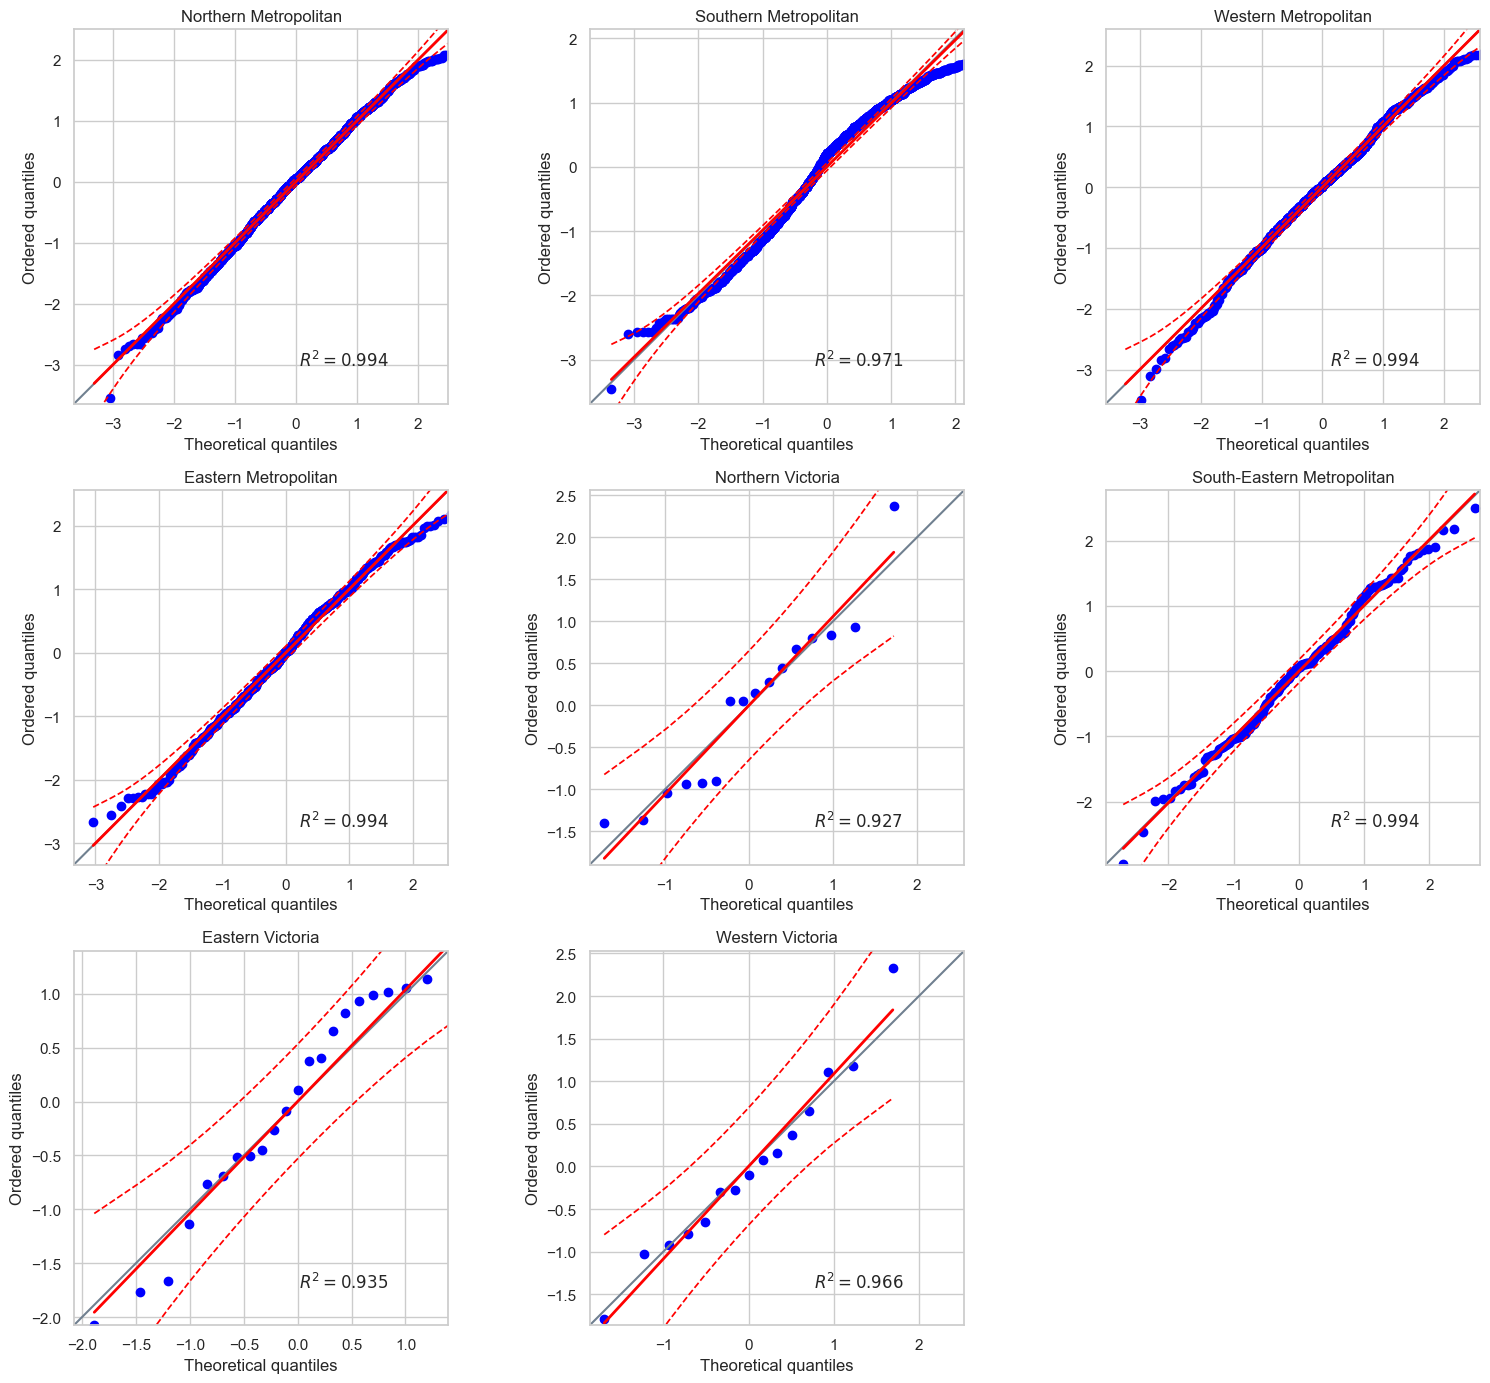

In [29]:
train_set['Price_log'] = np.log(train_set.Price)

qqplot_price_category(
    train_set, 
    target_col='Price_log',
    category_group = 'Regionname',
    input_shape = [3, 3],
    delete_last=True
)

In [30]:
pg.normality(
    data=train_set, 
    dv='Price_log', 
    group='Regionname'
)

W          pval  normal
Regionname                                                
Northern Metropolitan       0.993486  3.441152e-06   False
Southern Metropolitan       0.970169  1.958435e-18   False
Western Metropolitan        0.993523  6.131901e-05   False
Eastern Metropolitan        0.992174  4.115439e-03   False
Northern Victoria           0.925994  2.104936e-01    True
South-Eastern Metropolitan  0.993349  5.273652e-01    True
Eastern Victoria            0.919121  6.379469e-02    True
Western Victoria            0.975875  9.335374e-01    True

It is now more like a normal distribution of the prices divided by the regions.

So we can make now an ANOVA, to assess which is the influence of the Region Name on the logarithm of the pricing.

In [31]:
pg.anova(
    data=train_set, 
    dv='Price_log', 
    between='Regionname', 
    detailed=True
)

Source           SS    DF         MS          F          p-unc  \
0  Regionname   125.317728     7  17.902533  85.106268  1.168594e-117   
1      Within  1095.108342  5206   0.210355        NaN            NaN   

        np2  
0  0.102684  
1       NaN

We have very small **p-value**, which means that we could reject the null hyphotesis that the means of the logarithmic prices across Region Names are the same.

### Method

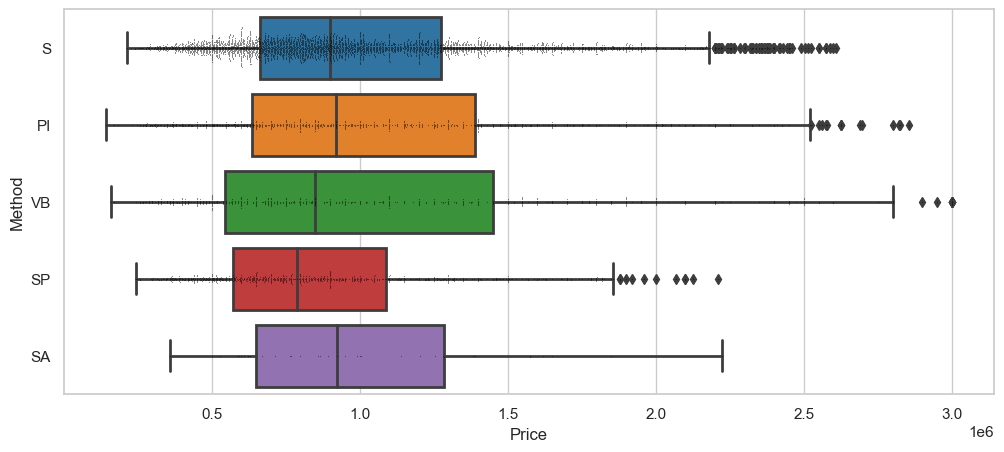

In [32]:
sns.boxplot(
    x='Price',
    y='Method',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Method", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

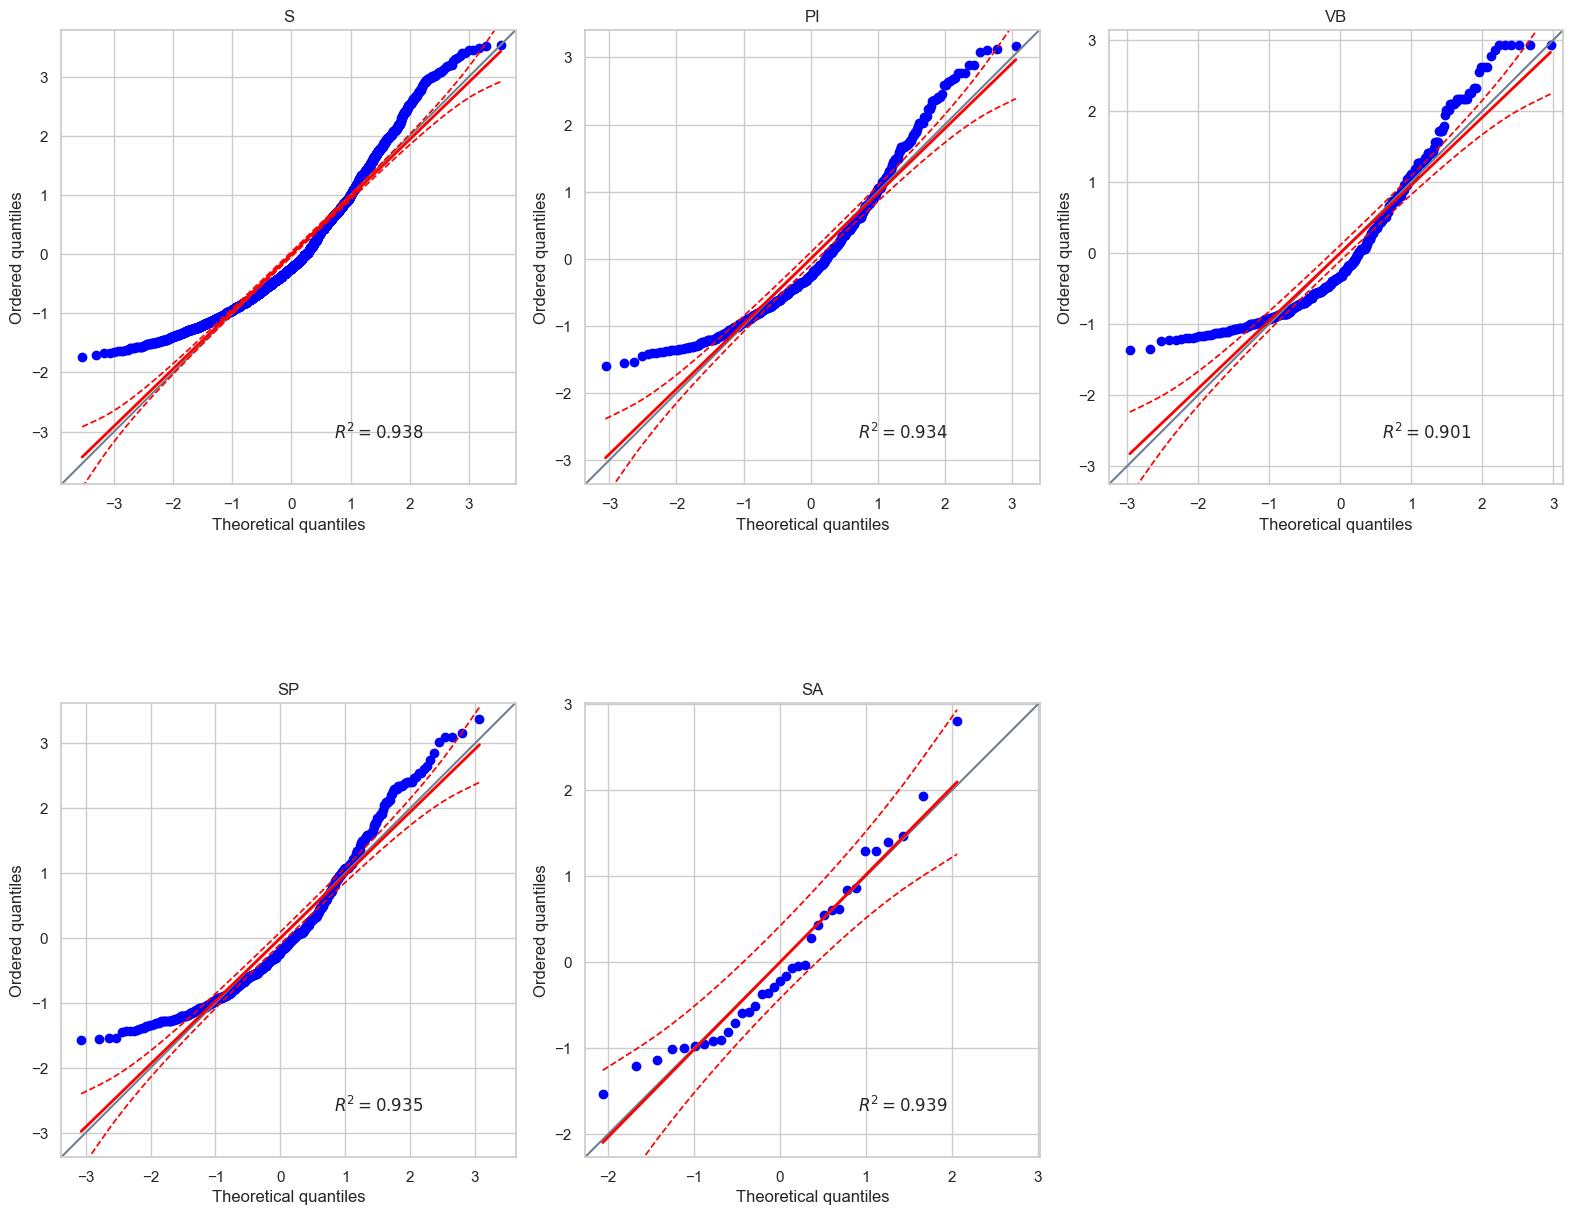

In [33]:
qqplot_price_category(
    train_set,
    category_group = 'Method',
    input_shape = [2, 3],
    delete_last=True
)

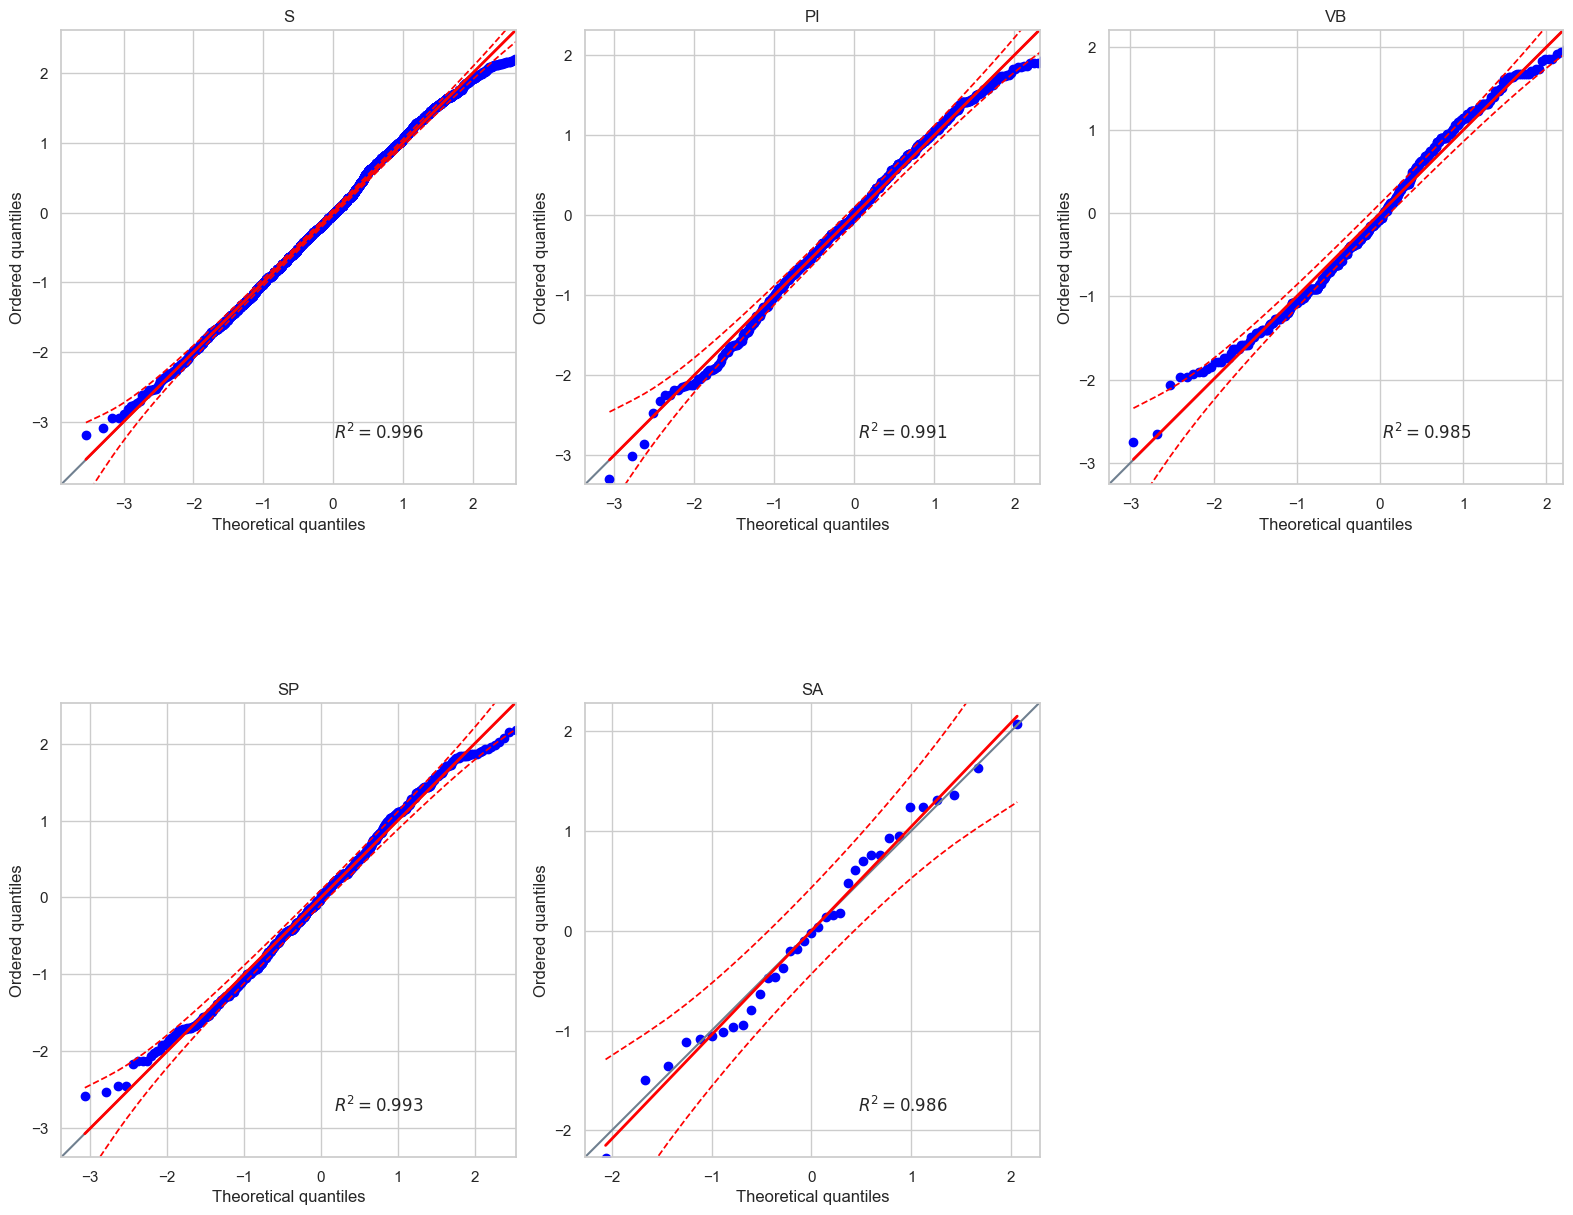

In [34]:
qqplot_price_category(
    train_set,
    target_col='Price_log',
    category_group = 'Method',
    input_shape = [2, 3],
    delete_last=True
)

## Numerical Variables

To start with this, we can first compute which is the correlation between the numerical variables.

<AxesSubplot: >

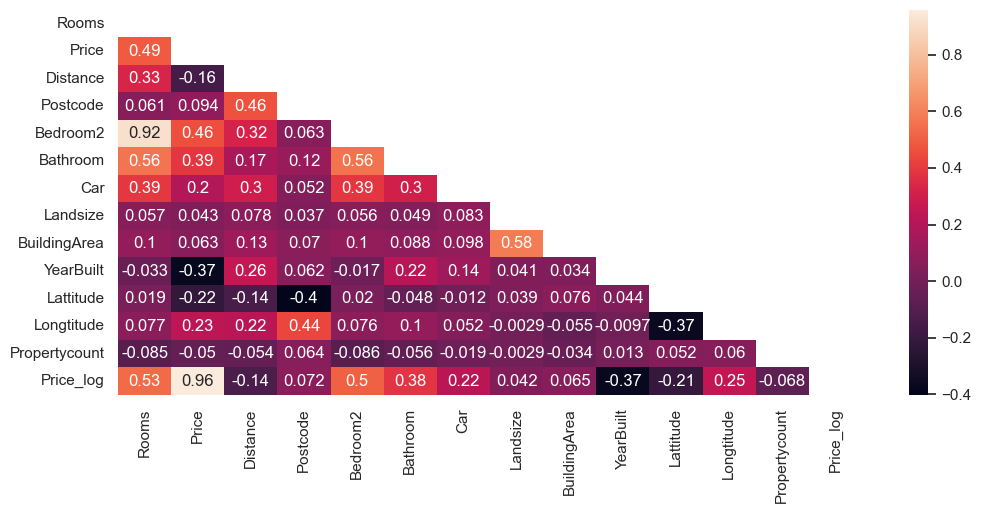

In [35]:
corr = train_set.corr(numeric_only=True)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(
    corr,
    annot=True,
    mask=matrix
)

So we can see that there are some variables with more correlation with price than logarithmic price:
- **Distance**
- **Bedroom2**
- **Bathroom**

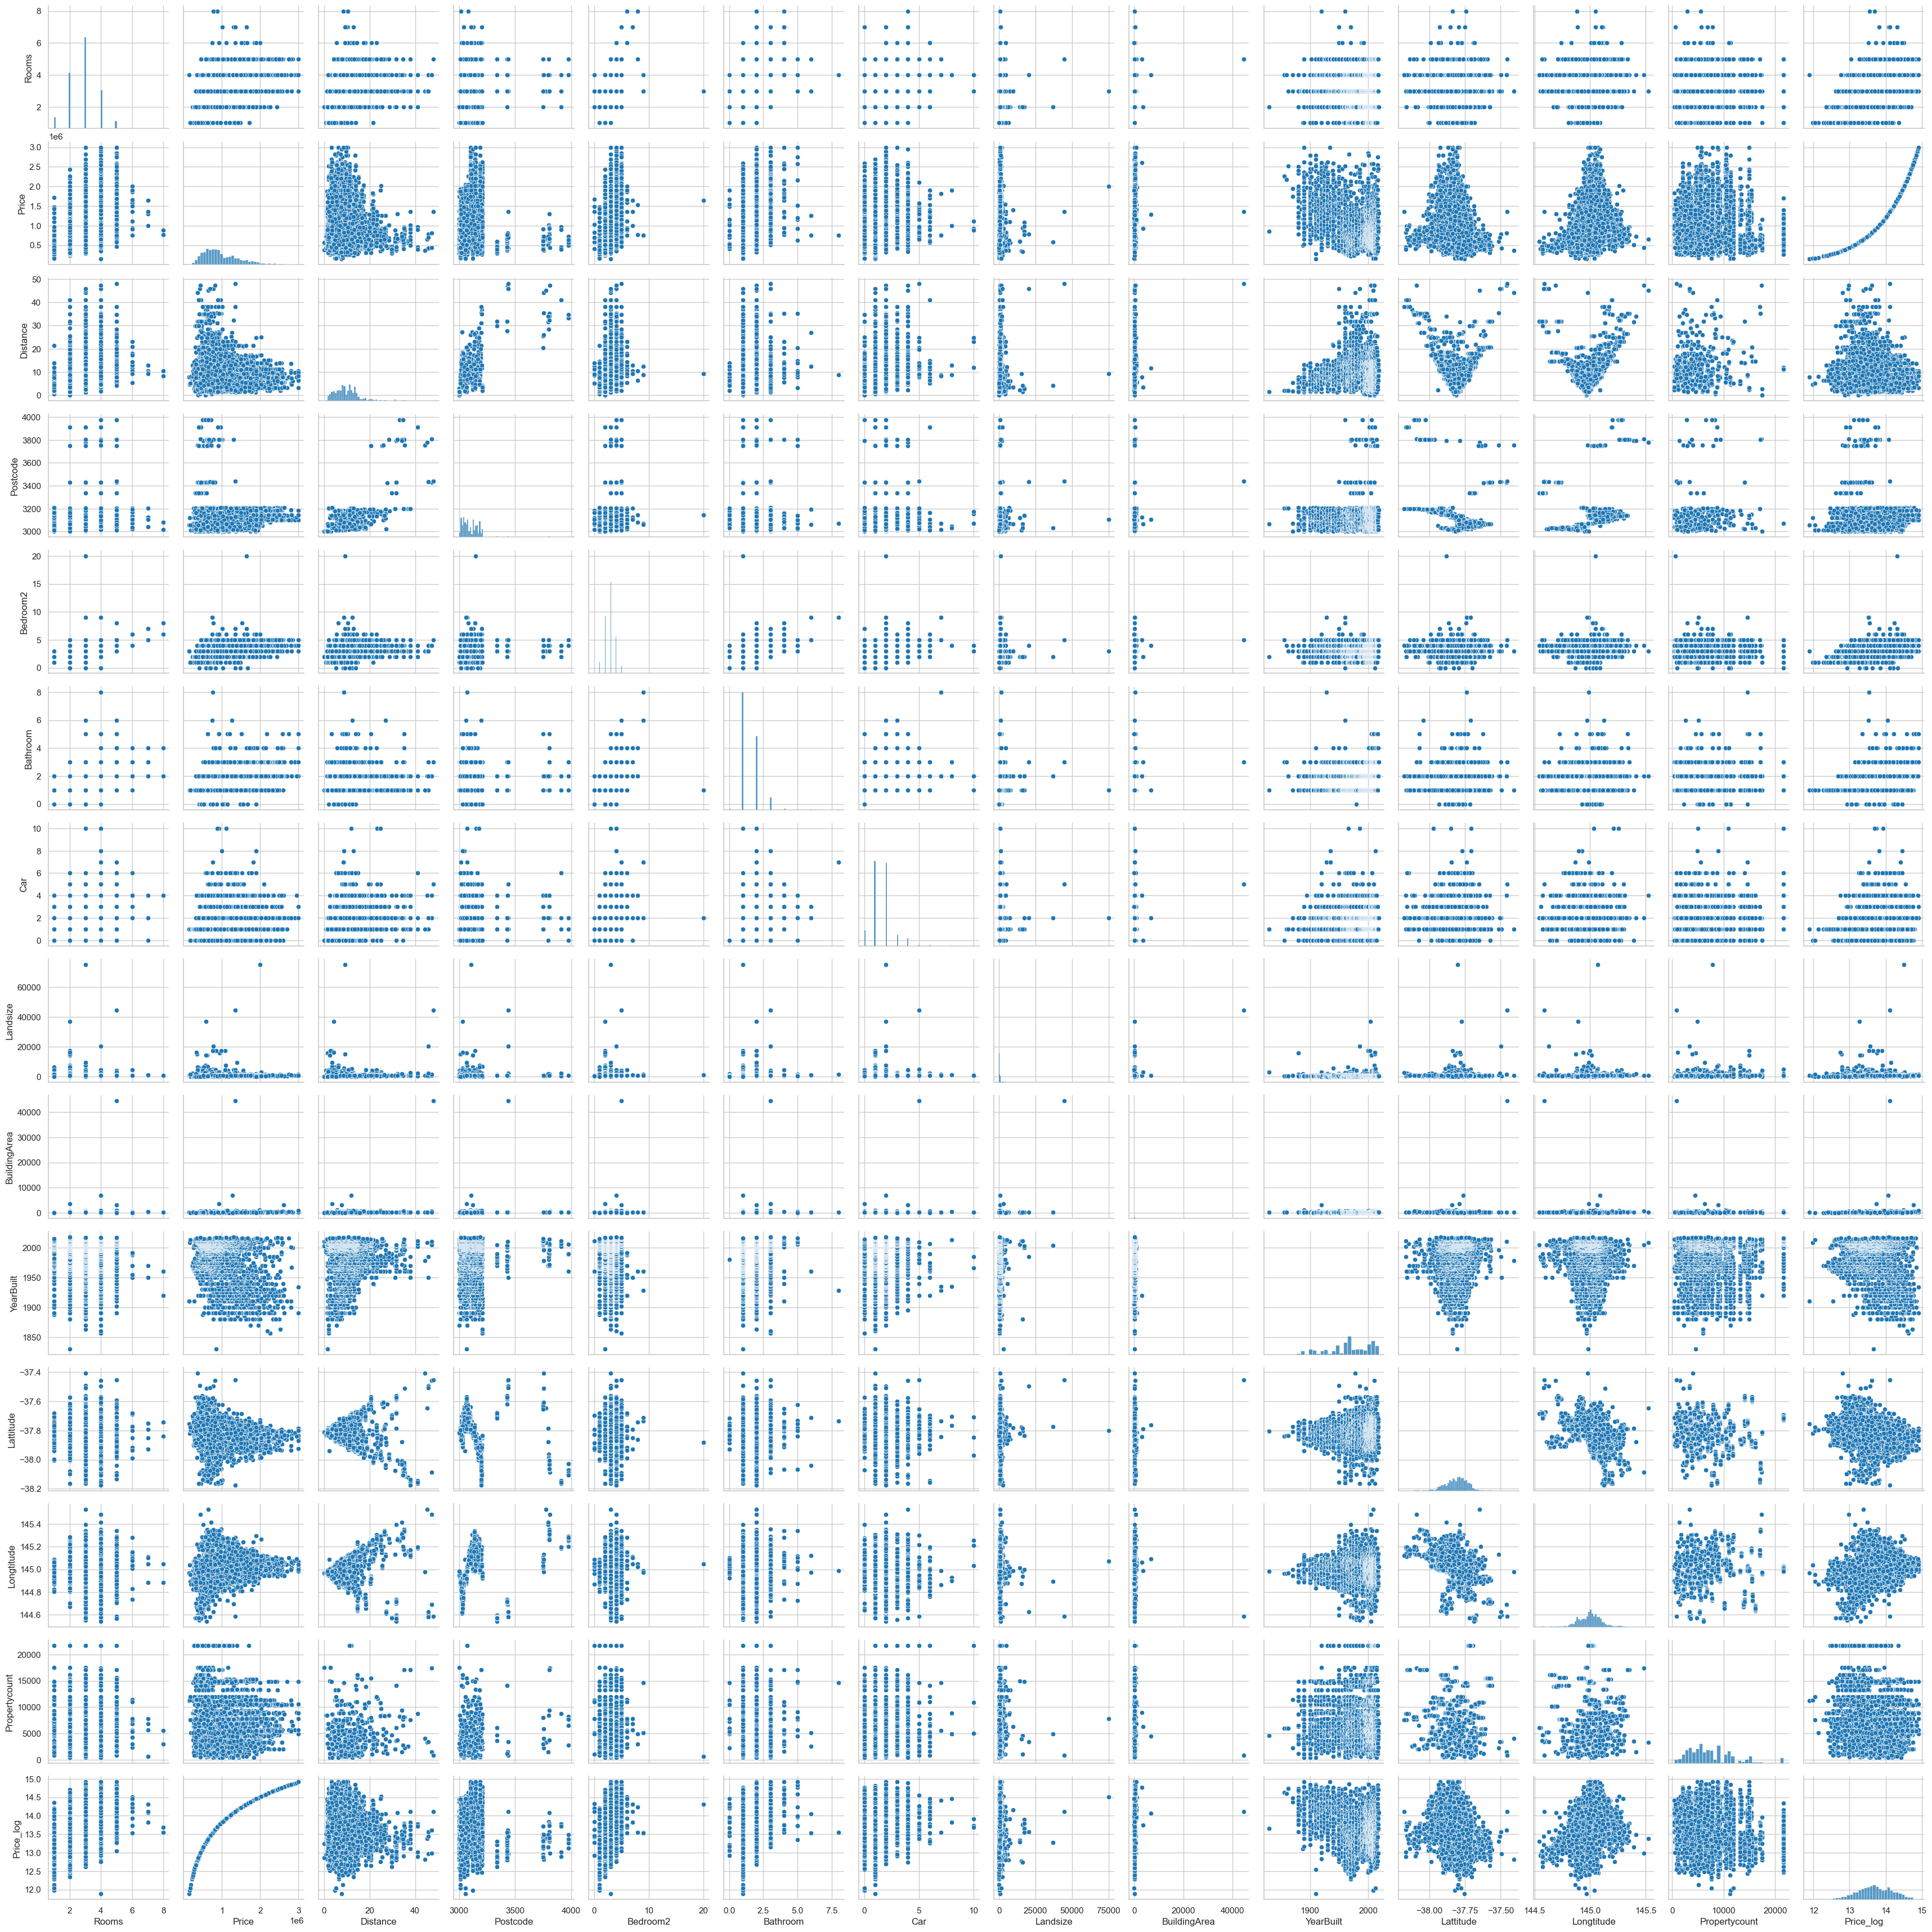

In [36]:
# We can create also pairplot so see how the distribution pairs are
sns.pairplot(
    train_set
)

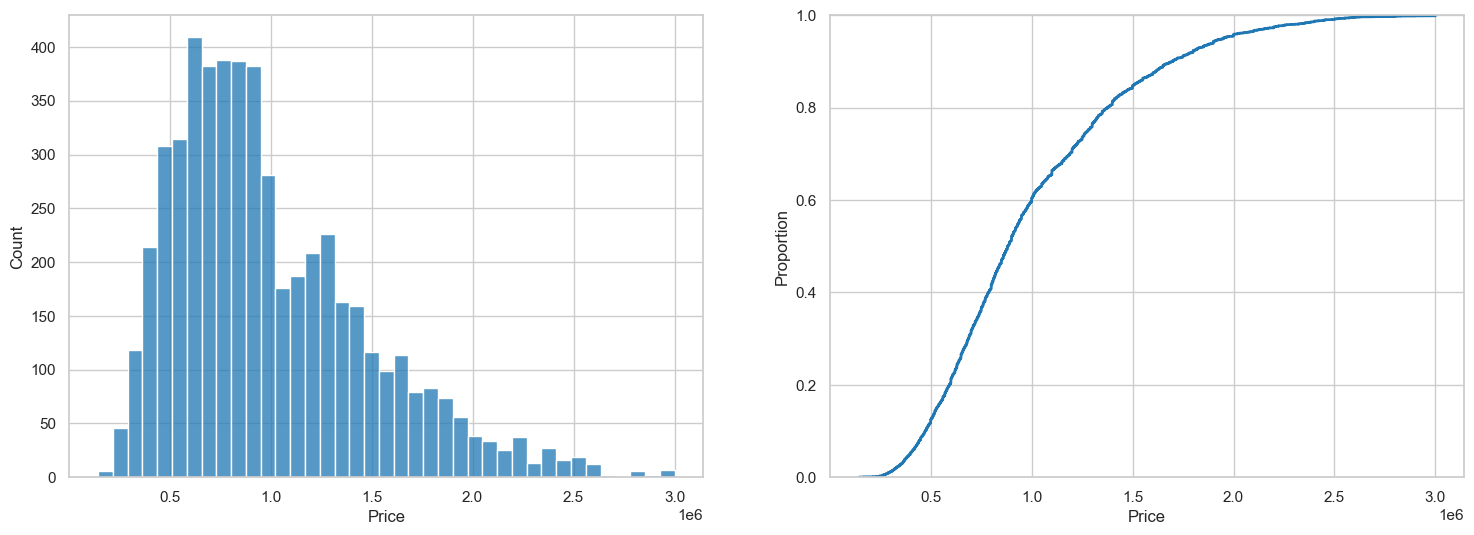

In [66]:
# We can plot more in detail the target variable
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(train_set['Price'], ax=ax1)
sns.ecdfplot(train_set['Price'], ax=ax2)
plt.show()

So we can see that more than 80% of the prices are below 150.000 dollars.

## Handling NaN

### YearBuilt

For the year built, we are going to compute the mean of the years in which is was built each suburb. 

Assumming the construction was by areas, and each small area is represented by a suburb.

In [ ]:
# Before doing so, we might want to see that the values of yearbuilt for each of suburbs are quite close

In [207]:
train_set['YearBuilt'] = train_set['YearBuilt']\
    .fillna(
        train_set\
            .groupby('Suburb')['YearBuilt']\
            .transform('median')
    )

# Feature Engineering

Date Feature Enginering:
- Year in which it was sold --> clustering kmeans from longitude/latitude to know which is the year


Normalization of features (for LR, in case of Trees not be necessary).

PCA.

22

## Longtitude & Lattitude

Instead of using PCA, which would lose the dimension of space, I will assume that there are groups for that location that are of relevent importance for the price.

<AxesSubplot: xlabel='Longtitude', ylabel='Lattitude'>

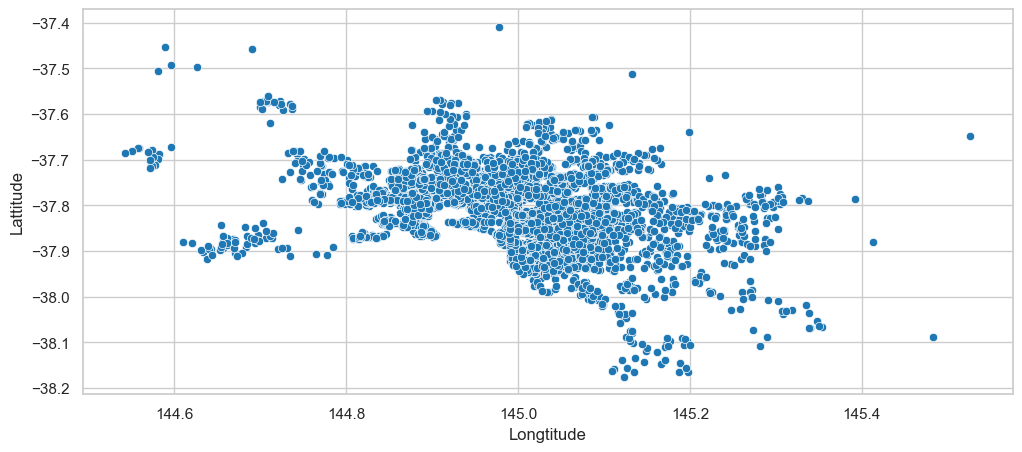

In [77]:
sns.scatterplot(
    data=train_set,
    x='Longtitude',
    y='Lattitude'
)

In [182]:
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

train_long_lat = train_set[['Longtitude', 'Lattitude']]
test_long_lat = test_set[['Longtitude', 'Lattitude']]

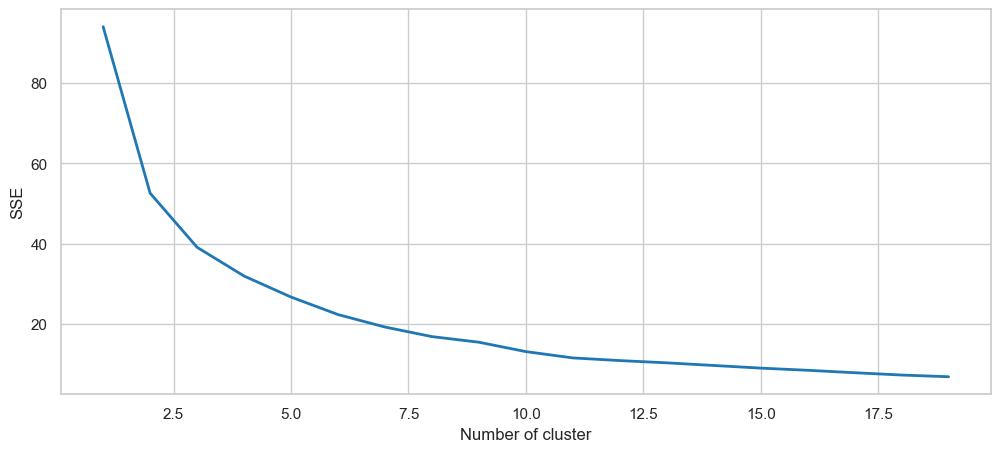

In [183]:
# Will watch which is the elbow

sse = {}
for k in range(1, 20):
    kmeans = KMeans(
        n_clusters=k, 
        max_iter=1000, 
        n_init='auto'
    ).fit(train_long_lat)
        
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [219]:
divisor = 11
n_features = math.floor((train_set['YearBuilt'].nunique() / divisor))

print('Number of features: ', n_features)
k_means = KMeans(
    n_clusters=n_features, 
    n_init='auto',
    max_iter=1000
)

k_means.fit(train_long_lat)

Number of features:  12


KMeans(max_iter=1000, n_clusters=12, n_init='auto')

In [220]:
# With the same model trained we predict both groups for test & trian
labels_train = k_means.labels_
labels_test = k_means.predict(test_long_lat)

In [221]:
centroides = k_means.cluster_centers_
etiquetas = k_means.labels_

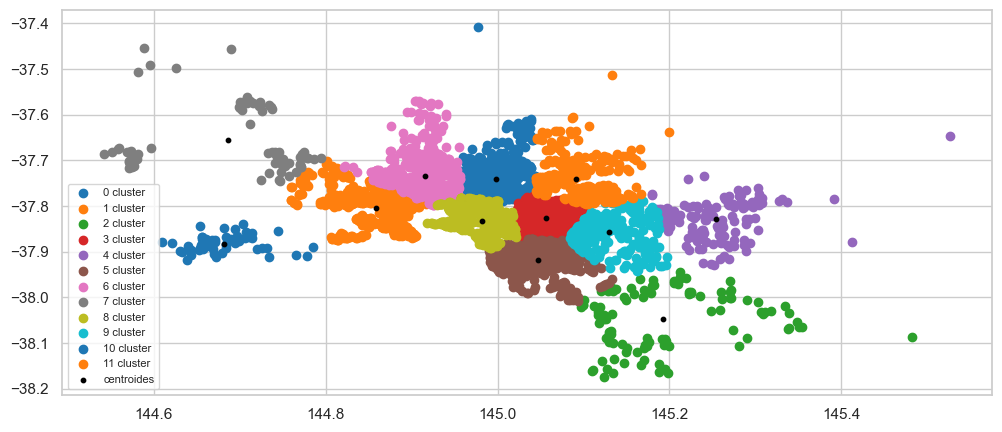

In [222]:
unique_labels = np.unique(labels_train)
 
for label in unique_labels:
    plt.scatter(
        X_long_lat.iloc[labels_train == label, 0], 
        X_long_lat.iloc[labels_train == label, 1], 
        label = f"{label} cluster",
    )

plt.scatter(
    centroides[:,0],
    centroides[:,1], 
    label='centroides', 
    color = 'k', 
    s=10
)

plt.legend(
    prop={'size': 8}
)
plt.show()

In [223]:
# Add this new feature into the dataframe
train_set['location_group'] = labels_train
test_set['location_group'] = labels_test

# Replace the other features we will no longer use


## Model Creation

In [237]:
from sklearn.neighbors import KNeighborsRegressor
n_neighbors = 3

X = train_set[['location_group', 'YearBuilt', 'Propertycount', 'BuildingArea', 'Bedroom2']]
X.fillna(0.0, inplace=True)
Y = train_set['Price']

model = KNeighborsRegressor(n_neighbors)
model.fit(X, Y)

/tmp/ipykernel_27065/2248455453.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0.0, inplace=True)


KNeighborsRegressor(n_neighbors=3)

In [238]:
y_pred = model.predict(X)

from sklearn.metrics import mean_squared_error, r2_score

mean_squared_error(Y, y_pred, squared=False)
r2_score(Y, y_pred)

0.741804252362015

## Linear Regression

## Decision Trees

## TODO's

- With one hot encoding, the U of Type could be skipped (multi-collinearity if we have all of them)
- Create model for predicting building area / landsize & infer nan -> LR for type of house and landsize
- Buildyear based on KNN, 
- Filter by the outliers 
- Each model for division
- Train/val split
- Data with same ranges as test (and same parameters for conversion/normalization)